<a href="https://colab.research.google.com/github/Mohamed-said-salah/satellite-segmentation-unet/blob/main/notebooks/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install & imports

In [ ]:
# !pip installs kept minimal and standard
!pip -q install torch torchvision torchaudio opencv-python pillow matplotlib tqdm

import os, io, re, glob, sys, zipfile, shutil, posixpath, random
import numpy as np
import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)

Device: cuda


# Config

In [ ]:
# === CONFIG ===
USE_REAL_DATA = True            # True = LandCover.ai v1 subset; False = synthetic demo
REAL_DATA_SUBSET = 16           # number of image/mask pairs to extract for Colab
TARGET_CLASS = "vegetation"     # "vegetation" (binary). (Multiclass requires code changes below)
TARGET_SIZE = (256, 256)        # (W, H) to which we resize all tiles
BATCH_SIZE = 8
EPOCHS = 10
LR = 1e-3
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Checkpoint paths
CKPT_DIR = "checkpoints"
BEST_CKPT = os.path.join(CKPT_DIR, "best_unet.pt")
LAST_CKPT = os.path.join(CKPT_DIR, "last_unet.pt")
os.makedirs(CKPT_DIR, exist_ok=True)

# Data download & preparation (LandCover.ai v1 with robust parsing) + synthetic fallback

In [ ]:
def fail(msg):
    print(msg)
    raise SystemExit(1)

os.makedirs('data', exist_ok=True)

if USE_REAL_DATA:
    zip_path = "landcover_ai.v1.zip"
    url = "https://landcover.ai.linuxpolska.com/download/landcover.ai.v1.zip"

    # Download if missing
    if not os.path.exists(zip_path):
        # follow redirects; fail on HTTP error; resume if possible
        !curl -L -f -C - -o {zip_path} {url}

    # Validate ZIP
    if not zipfile.is_zipfile(zip_path):
        print("Downloaded file is not a valid ZIP. First bytes:")
        with open(zip_path, "rb") as f:
            print(f.read(400).decode("utf-8", "ignore"))
        fail("Invalid ZIP. Check URL/network.")

    # Prepare folders
    for p in ["data/extracted", "data/images_png", "data/masks_png"]:
        if os.path.exists(p): shutil.rmtree(p)
        os.makedirs(p, exist_ok=True)

    # Helpers
    def read_image_from_zip(zf, name):
        data = zf.read(name)
        arr = np.frombuffer(data, np.uint8)
        img = cv2.imdecode(arr, cv2.IMREAD_UNCHANGED)
        return img

    with zipfile.ZipFile(zip_path) as z:
        tif_names = [n for n in z.namelist() if n.lower().endswith(('.tif','.tiff'))]
        if not tif_names:
            fail("No .tif/.tiff files found in the ZIP.")

        # Heuristic: try folder tokens
        img_cands  = [n for n in tif_names if re.search(r'/(images?|rgb|imgs)/', n.lower())]
        mask_cands = [n for n in tif_names if re.search(r'/(masks?|labels?|gt)/', n.lower())]

        # Fallback: content-based detection
        if not img_cands or not mask_cands:
            sample = tif_names[:60]
            imgs_found, masks_found = [], []
            for n in sample:
                try:
                    im = read_image_from_zip(z, n)
                    if im is None:
                        continue
                    if im.ndim == 3 and im.shape[2] >= 3:
                        imgs_found.append(n)
                    elif im.ndim == 2:
                        if len(np.unique(im)) <= 10:
                            masks_found.append(n)
                except:
                    pass
            if not img_cands:  img_cands  = imgs_found
            if not mask_cands: mask_cands = masks_found

        if not img_cands or not mask_cands:
            print("TIF names sample:\n", "\n".join(tif_names[:20]))
            fail("Could not auto-detect image/mask paths.")

        # Pair by filename stem
        def stem(p):
            base = posixpath.basename(p)
            return re.sub(r'\.(tif|tiff)$', '', base, flags=re.I)

        imgs_by_stem  = {stem(n): n for n in sorted(img_cands)}
        masks_by_stem = {stem(n): n for n in sorted(mask_cands)}

        common = [s for s in imgs_by_stem if s in masks_by_stem]
        if not common:
            # allow suffixes like _mask/_gt
            masks_by_stem2 = {}
            for s, n in masks_by_stem.items():
                s2 = re.sub(r'(_mask|_gt|_label)$', '', s, flags=re.I)
                masks_by_stem2[s2] = n
            common = [s for s in imgs_by_stem if s in masks_by_stem2]
            masks_by_stem = masks_by_stem2

        if not common:
            print("No matching stems. Example images:", list(imgs_by_stem)[:5])
            print("Example masks:", list(masks_by_stem)[:5])
            fail("Could not match image/mask pairs.")

        # Limit to subset
        common = common[:min(REAL_DATA_SUBSET, len(common))]

        # Convert to PNGs
        for s in common:
            img_name  = imgs_by_stem[s]
            mask_name = masks_by_stem[s]

            img = read_image_from_zip(z, img_name)
            msk = read_image_from_zip(z, mask_name)
            if img is None or msk is None:
                continue

            # Normalize image to 8-bit 3-channel RGB
            if img.dtype != np.uint8:
                mx = float(np.max(img)) if np.max(img) > 0 else 1.0
                img = cv2.convertScaleAbs(img, alpha=(255.0/mx))
            if img.ndim == 2:
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            elif img.ndim == 3 and img.shape[2] > 3:
                img = img[..., :3]

            out_base = s + ".png"
            cv2.imwrite(f"data/images_png/{out_base}", img)

            # Mask handling: binary vegetation = woodland (id 2)
            if msk.ndim == 3:
                msk = msk[...,0]
            if TARGET_CLASS == "vegetation":
                m = (msk == 2).astype(np.uint8) * 255  # woodland=2
            else:
                m = msk.astype(np.uint8)  # multiclass (not used in this notebook)
            cv2.imwrite(f"data/masks_png/{out_base}", m)

    IMG_DIR = "data/images_png"
    MSK_DIR = "data/masks_png"
    print("Using REAL LandCover.ai subset. PNGs ready.")

else:
    # Synthetic fallback (fast sanity check)
    for p in ["data/images", "data/masks"]:
        if os.path.exists(p): shutil.rmtree(p)
        os.makedirs(p, exist_ok=True)

    def synth_image(size=256):
        img = np.zeros((size, size, 3), dtype=np.uint8)
        mask = np.zeros((size, size), dtype=np.uint8)
        for _ in range(np.random.randint(2,5)):
            x1,y1 = np.random.randint(0,size//2,2)
            x2,y2 = x1+np.random.randint(size//4,size-10), y1+np.random.randint(size//4,size-10)
            color = np.random.randint(50,200, size=3)
            cv2.rectangle(img, (x1,y1), (x2,y2), color.tolist(), -1)
            cv2.rectangle(mask, (x1,y1), (x2,y2), 255, -1)
        noise = np.random.randint(0,30,(size,size,3),dtype=np.uint8)
        img = cv2.add(img, noise)
        return img, mask

    for i in range(240):
        im, mk = synth_image(256)
        cv2.imwrite(f'data/images/{i:04d}.png', im)
        cv2.imwrite(f'data/masks/{i:04d}.png', mk)

    IMG_DIR = "data/images"
    MSK_DIR = "data/masks"
    print("Using SYNTHETIC demo data.")

print("Images:", len(glob.glob(f'{IMG_DIR}/*.png')), "Masks:", len(glob.glob(f'{MSK_DIR}/*.png')))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1466M  100 1466M    0     0  10.0M      0  0:02:26  0:02:26 --:--:-- 10.5M
Using REAL LandCover.ai subset. PNGs ready.
Images: 16 Masks: 16


# Dataset (pairs + resize) and DataLoaders

In [ ]:
def _stem(path):
    return os.path.splitext(os.path.basename(path))[0]

def build_pairs(img_dir, msk_dir):
    imgs = sorted(glob.glob(os.path.join(img_dir, '*.png')))
    msks = sorted(glob.glob(os.path.join(msk_dir, '*.png')))
    by_img = {_stem(p): p for p in imgs}
    by_msk = {_stem(p): p for p in msks}
    common = sorted(set(by_img) & set(by_msk))
    if not common:
        raise RuntimeError("No matching image/mask stems. Check PNG names.")
    return [(by_img[s], by_msk[s]) for s in common]

class SegDataset(Dataset):
    def __init__(self, pairs, target_class="vegetation", target_size=(256,256)):
        self.pairs = pairs
        self.target_class = target_class
        self.target_size = target_size  # (W, H)

    def __len__(self): return len(self.pairs)

    def __getitem__(self, idx):
        img_path, msk_path = self.pairs[idx]
        img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
        msk = cv2.imread(msk_path, cv2.IMREAD_UNCHANGED)
        if img is None or msk is None:
            raise RuntimeError(f"Failed to read: {img_path} or {msk_path}")

        # RGB 3ch
        if img.ndim == 2:
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        elif img.ndim == 3 and img.shape[2] > 3:
            img = img[..., :3]

        # If mask has 3 channels (color map), take one channel
        if msk.ndim == 3:
            msk = msk[...,0]

        W, H = self.target_size
        img = cv2.resize(img, (W, H), interpolation=cv2.INTER_LINEAR)
        msk = cv2.resize(msk, (W, H), interpolation=cv2.INTER_NEAREST)

        img = img.astype(np.float32) / 255.0
        if self.target_class == "vegetation":
            msk = (msk > 127).astype(np.float32)  # binary
        else:
            msk = msk.astype(np.float32)         # (multiclass not used here)

        img = torch.from_numpy(img.transpose(2,0,1))  # (C,H,W)
        msk = torch.from_numpy(msk).unsqueeze(0)      # (1,H,W)
        return img, msk

pairs = build_pairs(IMG_DIR, MSK_DIR)
random.shuffle(pairs)
n = len(pairs)
split = max(1, int(0.8 * n))
train_pairs, val_pairs = pairs[:split], pairs[split:]

train_ds = SegDataset(train_pairs, target_class=TARGET_CLASS, target_size=TARGET_SIZE)
val_ds   = SegDataset(val_pairs,   target_class=TARGET_CLASS, target_size=TARGET_SIZE)

# Tip: num_workers=0 while debugging; you can increase to 2 later
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f"Pairs={n} | Train batches={len(train_loader)} | Val batches={len(val_loader)}")

Pairs=16 | Train batches=2 | Val batches=1


# Model (U-Net), loss, optimizer, metric

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1), nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)
        )
    def forward(self, x): return self.net(x)

class UNet(nn.Module):
    def __init__(self, in_c=3, out_c=1):
        super().__init__()
        self.d1 = DoubleConv(in_c, 64)
        self.d2 = DoubleConv(64, 128)
        self.d3 = DoubleConv(128, 256)
        self.d4 = DoubleConv(256, 512)
        self.u3 = DoubleConv(256+512, 256)
        self.u2 = DoubleConv(128+256, 128)
        self.u1 = DoubleConv(64+128, 64)
        self.out = nn.Conv2d(64, out_c, 1)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x1 = self.d1(x)
        x2 = self.d2(self.pool(x1))
        x3 = self.d3(self.pool(x2))
        x4 = self.d4(self.pool(x3))

        u3 = F.interpolate(x4, scale_factor=2, mode='bilinear', align_corners=False)
        u3 = torch.cat([u3, x3], 1); u3 = self.u3(u3)

        u2 = F.interpolate(u3, scale_factor=2, mode='bilinear', align_corners=False)
        u2 = torch.cat([u2, x2], 1); u2 = self.u2(u2)

        u1 = F.interpolate(u2, scale_factor=2, mode='bilinear', align_corners=False)
        u1 = torch.cat([u1, x1], 1); u1 = self.u1(u1)

        return self.out(u1)

model = UNet().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=LR)
bce = nn.BCEWithLogitsLoss()

def iou_score(pred, mask, thr=0.5, eps=1e-7):
    pred = (torch.sigmoid(pred) > thr).float()
    inter = (pred*mask).sum((1,2,3))
    union = (pred+mask - pred*mask).sum((1,2,3)) + eps
    return (inter/union).mean().item()

# Training loop (saves best and last checkpoints)

In [ ]:
best_iou = -1.0

for epoch in range(EPOCHS):
    # ---- Train ----
    model.train()
    tr_loss = 0.0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        logits = model(x)
        loss = bce(logits, y)
        loss.backward()
        opt.step()
        tr_loss += loss.item() * x.size(0)
    tr_loss /= max(1, len(train_loader.dataset))

    # ---- Validate ----
    model.eval()
    va_loss, va_iou = 0.0, 0.0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            va_loss += bce(logits, y).item() * x.size(0)
            va_iou  += iou_score(logits, y) * x.size(0)
    va_loss /= max(1, len(val_loader.dataset))
    va_iou  /= max(1, len(val_loader.dataset))

    print(f"Epoch {epoch+1:02d} | train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | val_mIoU={va_iou:.4f}")

    # always save "last"
    torch.save(model.state_dict(), LAST_CKPT)

    # save "best" if improved
    if va_iou > best_iou:
        best_iou = va_iou
        torch.save(model.state_dict(), BEST_CKPT)
        print(f"✅ Saved BEST checkpoint: mIoU={best_iou:.4f}")

Epoch 01 | train_loss=0.7048 | val_loss=0.6917 | val_mIoU=0.4991
✅ Saved BEST checkpoint: mIoU=0.4991
Epoch 02 | train_loss=0.5780 | val_loss=0.6904 | val_mIoU=0.0000
Epoch 03 | train_loss=0.5251 | val_loss=0.8317 | val_mIoU=0.0000
Epoch 04 | train_loss=0.4855 | val_loss=0.9888 | val_mIoU=0.0000
Epoch 05 | train_loss=0.4830 | val_loss=1.1959 | val_mIoU=0.0000
Epoch 06 | train_loss=0.4645 | val_loss=1.1135 | val_mIoU=0.0000
Epoch 07 | train_loss=0.4500 | val_loss=0.8756 | val_mIoU=0.0000
Epoch 08 | train_loss=0.4281 | val_loss=0.7364 | val_mIoU=0.0000
Epoch 09 | train_loss=0.4154 | val_loss=0.7308 | val_mIoU=0.0000
Epoch 10 | train_loss=0.4230 | val_loss=0.7966 | val_mIoU=0.0000


# Load checkpoint (best→last→current) & visualize predictions

Loaded BEST checkpoint.


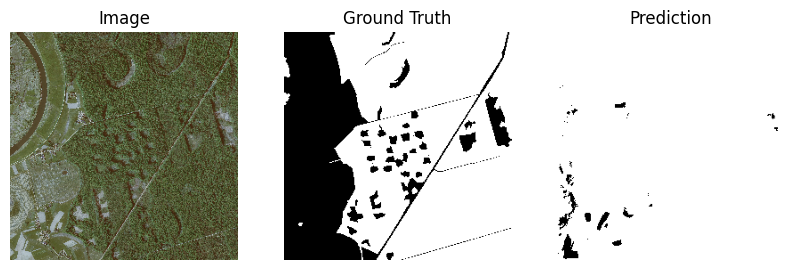

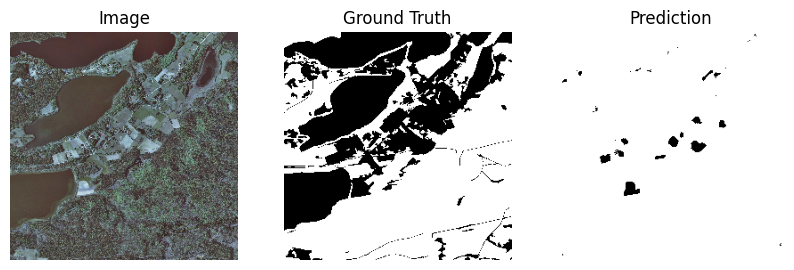

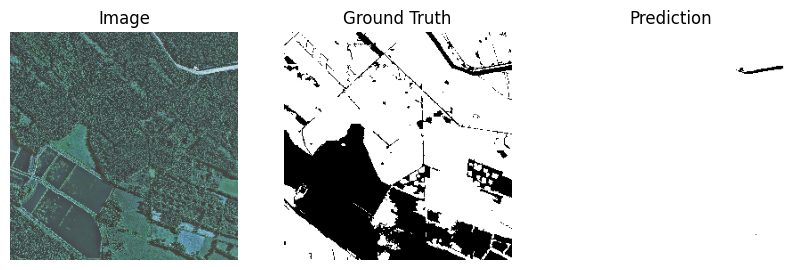

In [ ]:
# Load best → else last → else keep current
if os.path.exists(BEST_CKPT):
    model.load_state_dict(torch.load(BEST_CKPT, map_location=device))
    print("Loaded BEST checkpoint.")
elif os.path.exists(LAST_CKPT):
    model.load_state_dict(torch.load(LAST_CKPT, map_location=device))
    print("Loaded LAST checkpoint.")
else:
    print("⚠️ No checkpoint found. Using current weights.")
model.eval()

# Get a batch
try:
    batch = next(iter(val_loader))
except StopIteration:
    batch = next(iter(train_loader))

x, y = batch
with torch.no_grad():
    pred = torch.sigmoid(model(x.to(device))).cpu()

k = min(3, x.size(0))
for i in range(k):
    img = (x[i].permute(1,2,0).numpy()*255).astype(np.uint8)
    msk = (y[i,0].numpy()*255).astype(np.uint8)
    prd = (pred[i,0].numpy()>0.5).astype(np.uint8)*255
    fig,ax = plt.subplots(1,3,figsize=(10,4))
    ax[0].imshow(img); ax[0].set_title('Image'); ax[0].axis('off')
    ax[1].imshow(msk, cmap='gray'); ax[1].set_title('Ground Truth'); ax[1].axis('off')
    ax[2].imshow(prd, cmap='gray'); ax[2].set_title('Prediction'); ax[2].axis('off')
    plt.show()

# Auto-generate a summary block

summary_md = f"""
# 🛰️ Satellite Segmentation with U-Net — Summary Report

**Mode:** {'Real LandCover.ai subset' if USE_REAL_DATA else 'Synthetic demo'}
**Target:** {TARGET_CLASS} (binary)
**Tile size:** {TARGET_SIZE[1]}×{TARGET_SIZE[0]} | **Epochs:** {EPOCHS} | **Batch:** {BATCH_SIZE}

## Abstract
This project applies a compact U-Net to segment satellite imagery. It demonstrates real-data preprocessing (LandCover.ai v1), model training in PyTorch, and evaluation via mean IoU.

## Dataset
{"- **Source:** LandCover.ai v1 (Sentinel-2 derived, RGB and mask in GeoTIFF)\n- **Subset:** "
 + str(REAL_DATA_SUBSET) +
 " paired tiles extracted in Colab for compute efficiency\n- **Classes (original):** 0 background, 1 buildings, 2 woodland, 3 water, 4 others\n- **Task conversion:** Binary vegetation (woodland=2) vs non-vegetation"
 if USE_REAL_DATA else
 "- **Synthetic demo:** Procedurally generated RGB tiles with binary masks for rapid sanity checks"
}

## Model
- Architecture: U-Net encoder–decoder with skip connections
- Loss: BCEWithLogitsLoss (binary)
- Optimizer: AdamW (lr = {LR})
- Metric: mean Intersection-over-Union (mIoU)

## Results
- **Best validation mIoU:** ~ {round(float(globals().get('best_iou', -1.0)), 3) if 'best_iou' in globals() else 'N/A'}
- Qualitative predictions are shown below (image, ground truth, prediction).

## Future Work
- Train on the full dataset and/or more tiles
- Switch to multi-class segmentation (buildings, water, vegetation, others)
- Add data augmentation (albumentations), mixed precision, LR scheduling
- Incorporate spectral indices (e.g., NDVI/NDBI) for improved performance
""".strip()

print(summary_md)

# Save artifacts to Google Drive for persistence

In [ ]:
# Uncomment if you want persistence across sessions / Comment if not
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p /content/drive/MyDrive/landcover_cache
!cp -r data/images_png data/masks_png /content/drive/MyDrive/landcover_cache/ 2>/dev/null
!mkdir -p /content/drive/MyDrive/unet_checkpoints
!cp -r checkpoints/* /content/drive/MyDrive/unet_checkpoints/ 2>/dev/null
print("Optional: mount Drive and copy data/checkpoints there to persist.")

Mounted at /content/drive
Optional: mount Drive and copy data/checkpoints there to persist.
